In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

% matplotlib inline
% load_ext autoreload
% autoreload 2

UsageError: Line magic function `%` not found.


In [2]:
train_x1 = torch.linspace(0, 1, 50)
train_x2 = train_x1

train_y1 = torch.ones_like(train_x1)+math.sqrt(0.1)*torch.rand_like(train_x1)
train_y2 = 0.8*train_y1-2
train_y1[-1] = 2


In [3]:
class MultitaskGPModel(gpytorch.models.ExactGP):
  def __init__(self, train_x, train_y, likelihood):
    super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
    self.mean_module = gpytorch.means.ConstantMean()
    self.covar_module = gpytorch.kernels.RBFKernel()

    # We learn an IndexKernel for 2 tasks
    # (so we'll actually learn 2x2=4 tasks with correlations)
    self.task_covar_module = gpytorch.kernels.IndexKernel(num_tasks=2, rank=1)

  def forward(self, x, i):
    mean_x = self.mean_module(x)

    # Get input-input covariance
    covar_x = self.covar_module(x)
    # Get task-task covariance
    covar_i = self.task_covar_module(i)
    # Multiply the two together to get the covariance we want
    covar = covar_x.mul(covar_i)

    return gpytorch.distributions.MultivariateNormal(mean_x, covar)


likelihood = gpytorch.likelihoods.GaussianLikelihood()

train_i_task1 = torch.full_like(train_x1, dtype=torch.long, fill_value=0)
train_i_task2 = torch.full_like(train_x2, dtype=torch.long, fill_value=1)

full_train_x = torch.cat([train_x1, train_x2])
full_train_i = torch.cat([train_i_task1, train_i_task2])
full_train_y = torch.cat([train_y1, train_y2])

# Here we have two iterms that we're passing in as train_inputs
model = MultitaskGPModel((full_train_x, full_train_i), full_train_y, likelihood)

In [6]:
# this is for running the notebook in our testing framework
import os

smoke_test = ('CI' in os.environ)
training_iterations = 2 if smoke_test else 150

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
  {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iterations):
  optimizer.zero_grad()
  output = model(full_train_x, full_train_i)
  loss = -mll(output, full_train_y)
  loss.backward()
  print('Iter %d/50 - Loss: %.3f' % (i + 1, loss.item()))
  optimizer.step()

Iter 1/50 - Loss: -0.629
Iter 2/50 - Loss: 0.470
Iter 3/50 - Loss: -0.561
Iter 4/50 - Loss: -0.419
Iter 5/50 - Loss: -0.068
Iter 6/50 - Loss: -0.182
Iter 7/50 - Loss: -0.453
Iter 8/50 - Loss: -0.602
Iter 9/50 - Loss: -0.576
Iter 10/50 - Loss: -0.468
Iter 11/50 - Loss: -0.390
Iter 12/50 - Loss: -0.392
Iter 13/50 - Loss: -0.455
Iter 14/50 - Loss: -0.530
Iter 15/50 - Loss: -0.578
Iter 16/50 - Loss: -0.583
Iter 17/50 - Loss: -0.556
Iter 18/50 - Loss: -0.523
Iter 19/50 - Loss: -0.508
Iter 20/50 - Loss: -0.521
Iter 21/50 - Loss: -0.553
Iter 22/50 - Loss: -0.588
Iter 23/50 - Loss: -0.610
Iter 24/50 - Loss: -0.613
Iter 25/50 - Loss: -0.603
Iter 26/50 - Loss: -0.590
Iter 27/50 - Loss: -0.586
Iter 28/50 - Loss: -0.594
Iter 29/50 - Loss: -0.610
Iter 30/50 - Loss: -0.624
Iter 31/50 - Loss: -0.629
Iter 32/50 - Loss: -0.625
Iter 33/50 - Loss: -0.617
Iter 34/50 - Loss: -0.610
Iter 35/50 - Loss: -0.609
Iter 36/50 - Loss: -0.614
Iter 37/50 - Loss: -0.621
Iter 38/50 - Loss: -0.625
Iter 39/50 - Loss: -0.

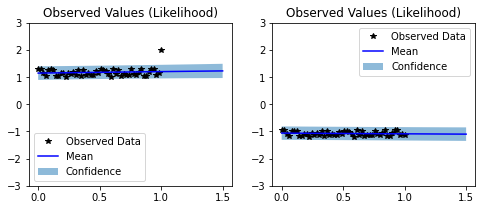

In [7]:
# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots
f, (y1_ax, y2_ax) = plt.subplots(1, 2, figsize=(8, 3))

# Test points every 0.02 in [0,1]
test_x = torch.linspace(0, 1.5, 71)
tast_i_task1 = torch.full_like(test_x, dtype=torch.long, fill_value=0)
test_i_task2 = torch.full_like(test_x, dtype=torch.long, fill_value=1)

# Make predictions - one task at a time
# We control the task we cae about using the indices

# The gpytorch.settings.fast_pred_var flag activates LOVE (for fast variances)
# See https://arxiv.org/abs/1803.06058
with torch.no_grad(), gpytorch.settings.fast_pred_var():
  observed_pred_y1 = likelihood(model(test_x, tast_i_task1))
  observed_pred_y2 = likelihood(model(test_x, test_i_task2))


# Define plotting function
def ax_plot(ax, train_y, train_x, rand_var, title):
  # Get lower and upper confidence bounds
  lower, upper = rand_var.confidence_region()
  # Plot training data as black stars
  ax.plot(train_x.detach().numpy(), train_y.detach().numpy(), 'k*')
  # Predictive mean as blue line
  ax.plot(test_x.detach().numpy(), rand_var.mean.detach().numpy(), 'b')
  # Shade in confidence
  ax.fill_between(test_x.detach().numpy(), lower.detach().numpy(), upper.detach().numpy(), alpha=0.5)
  ax.set_ylim([-3, 3])
  ax.legend(['Observed Data', 'Mean', 'Confidence'])
  ax.set_title(title)


# Plot both tasks
ax_plot(y1_ax, train_y1, train_x1, observed_pred_y1, 'Observed Values (Likelihood)')
ax_plot(y2_ax, train_y2, train_x2, observed_pred_y2, 'Observed Values (Likelihood)')

In [8]:
inter=torch.linspace(1,2,20)
train_y1[-20:]=inter
n_full_train_y = torch.cat([train_y1, train_y2])
model.set_train_data((full_train_x, full_train_i), n_full_train_y)

In [31]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
  {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(10):
  optimizer.zero_grad()
  output = model(full_train_x, full_train_i)
  loss = -mll(output, n_full_train_y)
  loss.backward()
  print('Iter %d/50 - Loss: %.3f' % (i + 1, loss.item()))
  optimizer.step()

Iter 1/50 - Loss: -0.889
Iter 2/50 - Loss: -0.857
Iter 3/50 - Loss: -0.887
Iter 4/50 - Loss: -0.884
Iter 5/50 - Loss: -0.874
Iter 6/50 - Loss: -0.882
Iter 7/50 - Loss: -0.890
Iter 8/50 - Loss: -0.888
Iter 9/50 - Loss: -0.883
Iter 10/50 - Loss: -0.882


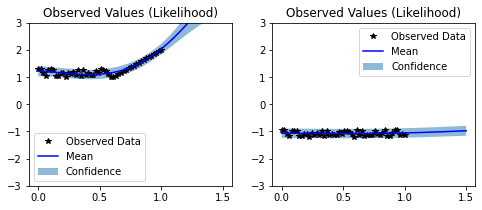

In [32]:
# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots
f, (y1_ax, y2_ax) = plt.subplots(1, 2, figsize=(8, 3))

# Test points every 0.02 in [0,1]
test_x = torch.linspace(0, 1.5, 51)
tast_i_task1 = torch.full_like(test_x, dtype=torch.long, fill_value=0)
test_i_task2 = torch.full_like(test_x, dtype=torch.long, fill_value=1)

# Make predictions - one task at a time
# We control the task we cae about using the indices

# The gpytorch.settings.fast_pred_var flag activates LOVE (for fast variances)
# See https://arxiv.org/abs/1803.06058
with torch.no_grad(), gpytorch.settings.fast_pred_var():
  observed_pred_y1 = likelihood(model(test_x, tast_i_task1))
  observed_pred_y2 = likelihood(model(test_x, test_i_task2))


# Define plotting function
def ax_plot(ax, train_y, train_x, rand_var, title):
  # Get lower and upper confidence bounds
  lower, upper = rand_var.confidence_region()
  # Plot training data as black stars
  ax.plot(train_x.detach().numpy(), train_y.detach().numpy(), 'k*')
  # Predictive mean as blue line
  ax.plot(test_x.detach().numpy(), rand_var.mean.detach().numpy(), 'b')
  # Shade in confidence
  ax.fill_between(test_x.detach().numpy(), lower.detach().numpy(), upper.detach().numpy(), alpha=0.5)
  ax.set_ylim([-3, 3])
  ax.legend(['Observed Data', 'Mean', 'Confidence'])
  ax.set_title(title)


# Plot both tasks
ax_plot(y1_ax, train_y1, train_x1, observed_pred_y1, 'Observed Values (Likelihood)')
ax_plot(y2_ax, train_y2, train_x2, observed_pred_y2, 'Observed Values (Likelihood)')

In [ ]:
import timeit
import time

start = timeit.default_timer()
time.sleep(3)
stop = timeit.default_timer()
print('Time: ', stop - start)

## Interpolation

In [ ]:
import scipy
import numpy as np
import torch
import torch.nn.functional as F
import scipy.interpolate
import pandas as pd

In [ ]:
a = torch.ones((14, 1))
b = torch.ones((1, 1)) * 2

In [ ]:
c = torch.cat((a, b))
# c[10:14, 0] = torch.nan

In [ ]:
d = F.interpolate(c, [15, 1], mode='cubic')

In [ ]:
c_n = c.numpy()
x = np.arange(0, c_n.shape[0]).reshape((15, 1))
x[-1, 0] = 20

In [ ]:
s = pd.Series(c_n)

In [ ]:
s.interpolate()

In [ ]:
z = scipy.interpolate.interp1d(x.squeeze(), c_n, axis=0, kind='quadratic')

In [ ]:
for i in range(21):
  print("i:", i, z(i))

In [ ]:
import torch

import RatInteractionDataLoader as ridl
import time
from model import Label, dynamicagent


def main():
  data_dir = 'dataset/'

  label_prefix = 'smuro-interaction-'
  label_data = '1028'
  label_time = '-0834pm'
  # label_suffix = '-short.csv'
  label_suffix = '-restored.mat'
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  # print('device is', device)

  file_path = data_dir + label_data + '/' + label_prefix + label_data + label_time + label_suffix

  # all_data = ridl.load_csv_data(file_path, mformat_header=False).to_numpy() * 60
  all_data = ridl.load_mat_file(file_path)['imputed_data']
  tensor_data = torch.tensor(all_data, dtype=torch.float64).to(device)
  # print(all_data[:3, :2])

  print(tensor_data.shape)

  t_dura_1s = 240  # 240 frames for 1s
  start_time = 0
  end_time = 10
  sample = 1
  gaussian_window = 24 * 5

  data_time_index = 0
  points_number = 4  # load 4 points to test
  data_time = tensor_data[:gaussian_window, 0]
  data_pos = tensor_data[:gaussian_window, 1:3 * points_number + 1]
  print('data device', data_time.device)
  print('data device', data_pos.device)

  labeler = Label(data_time, data_pos, device=device, max_iter=150)

  labeler.optimize()
  test_time = tensor_data[gaussian_window, 0].view(-1)  # time value should be Nx1 shape
  test_pos = tensor_data[gaussian_window, 1:].view(1, -1)
  aha = labeler.predict(test_time, test_pos)
  print('predication shape:', aha.shape)
  print('and its items:', aha)
  print('test pos is:', test_pos[0, :12])
  # aha shape should be [1,14*3]


def test():
  data_dir = 'dataset/'

  label_prefix = 'smuro-interaction-'
  label_data = '1028'
  label_time = '-0834pm'
  # label_suffix = '-short.csv'
  label_suffix = '-restored.mat'
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  # print('device is', device)

  file_path = data_dir + label_data + '/' + label_prefix + label_data + label_time + label_suffix

  # all_data = ridl.load_csv_data(file_path, mformat_header=False).to_numpy() * 60
  all_data = ridl.load_mat_file(file_path)['imputed_data']
  tensor_data = torch.tensor(all_data, dtype=torch.float64).to(device)
  agent = dynamicagent.DynamicAgent(tensor_data, save_mat='result.mat')

  # data = ridl.load_mat_file('dataset/restored_data.mat')
  # print('data type', type(data))
  # print('data contents', data['imputed_data'][:3, :3])


if __name__ == '__main__':
  # main()
  test()


In [ ]:
import numpy as np
import scipy.interpolate as interpolate
import matplotlib.pyplot as plt


def func(x, y, z):
    return x ** 2 + y ** 2 + z ** 2

# Nx, Ny, Nz = 181, 181, 421
Nx, Ny, Nz = 18, 18, 42

subsample = 2
Mx, My, Mz = Nx // subsample, Ny // subsample, Nz // subsample

# Define irregularly spaced arrays
x = np.random.random(Nx)
y = np.random.random(Ny)
z = np.random.random(Nz)

# Compute the matrix D of shape (Nx, Ny, Nz).
# D could be experimental data, but here I'll define it using func
# D[i,j,k] is associated with location (x[i], y[j], z[k])
X_irregular, Y_irregular, Z_irregular = (
    x[:, None, None], y[None, :, None], z[None, None, :])
D = func(X_irregular, Y_irregular, Z_irregular)

# Create a uniformly spaced grid
xi = np.linspace(x.min(), x.max(), Mx)
yi = np.linspace(y.min(), y.max(), My)
zi = np.linspace(y.min(), y.max(), Mz)
X_uniform, Y_uniform, Z_uniform = (
    xi[:, None, None], yi[None, :, None], zi[None, None, :])

# To use griddata, I need 1D-arrays for x, y, z of length 
# len(D.ravel()) = Nx*Ny*Nz.
# To do this, I broadcast up my *_irregular arrays to each be 
# of shape (Nx, Ny, Nz)
# and then use ravel() to make them 1D-arrays
X_irregular, Y_irregular, Z_irregular = np.broadcast_arrays(
    X_irregular, Y_irregular, Z_irregular)
D_interpolated = interpolate.griddata(
    (X_irregular.ravel(), Y_irregular.ravel(), Z_irregular.ravel()),
    D.ravel(),
    (X_uniform, Y_uniform, Z_uniform),
    method='linear')

print(D_interpolated.shape)
# (90, 90, 210)

# Make plots
fig, ax = plt.subplots(2)

# Choose a z value in the uniform z-grid
# Let's take the middle value
zindex = Mz // 2
z_crosssection = zi[zindex]

# Plot a cross-section of the raw irregularly spaced data
X_irr, Y_irr = np.meshgrid(sorted(x), sorted(y))
# find the value in the irregular z-grid closest to z_crosssection
z_near_cross = z[(np.abs(z - z_crosssection)).argmin()]
ax[0].contourf(X_irr, Y_irr, func(X_irr, Y_irr, z_near_cross))
ax[0].scatter(X_irr, Y_irr, c='white', s=20)   
ax[0].set_title('Cross-section of irregular data')
ax[0].set_xlim(x.min(), x.max())
ax[0].set_ylim(y.min(), y.max())

# Plot a cross-section of the Interpolated uniformly spaced data
X_unif, Y_unif = np.meshgrid(xi, yi)
ax[1].contourf(X_unif, Y_unif, D_interpolated[:, :, zindex])
ax[1].scatter(X_unif, Y_unif, c='white', s=20)
ax[1].set_title('Cross-section of downsampled and interpolated data')
ax[1].set_xlim(x.min(), x.max())
ax[1].set_ylim(y.min(), y.max())

plt.show()

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig = plt.figure()
ax=fig.add_subplot()
def f(x, y):
    return np.sin(x+y)
x = np.linspace(0, 2 * np.pi, 120)
ims = []
for i in np.linspace(0,2,100):
    im,=ax.plot(x,f(x,i),'r')
    title= ax.text(0.5,1.05,"time = {:.2f}s".format(i), 
                    size=plt.rcParams["axes.titlesize"],
                    ha="center", transform=ax.transAxes, )
    ims.append([im,title])
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=False)
ani.save("sin.gif",writer='pillow')
plt.show()